Actions each agent have to decide between: Leave or Stay 

In [141]:
import numpy as np

class Agent: 
    def __init__(self, music_taste = 1, strategy = 1, nr_concerts = int, festival_duration=int, dynamic_strategy='-'):
        self.music_taste = music_taste
        self.dist_from_stage = 0
        self.position_utility = 0
        self.waiting_utility_history = np.zeros(festival_duration)
        self.strategy = strategy
        self.position_utility_history = np.zeros(festival_duration)
        self.concert_history = np.ones(festival_duration, dtype=int)*(nr_concerts-1)
        self.concert_history[0] = 0 #start at first concert 
        if not isinstance(strategy, str):
            self.time_to_leave = strategy
        else:
            self.time_to_leave = 5
        self.dynamic_strategy = dynamic_strategy
    
class Concert:
    def __init__(self, len_rows = int, music_type = 1, capacity = 10, duration = int, nr_of_agents = int):
        self.len_rows = len_rows
        self.music_type = music_type
        self.nr_agents = 0
        self.nr_waiting_agents = 0
        self.capacity = capacity
        self.nr_rows = np.ceil(capacity/len_rows)
        self.duration = duration #timesteps
        self.agents = np.zeros(nr_of_agents)

    def add_agent(self):
        self.nr_agents += 1

def get_placement_utility(concert):
    placement_factor = 5
    #continuing using sigmoid
    #fullness = concert.nr_agents / concert.capacity
    #sigmoid_x = 1 - fullness
    #k = 10 #steepness of sigomid
    #center = 0.5 #[0,1] with 0.1 happy crowd and 0.9 happy front row
    #utility = placement_factor * 1 / ( 1 + np.exp(-k*(sigmoid_x- center)))

    #stepwise by which row the agent is in, sensitive to concert row length
    dist_from_stage = np.floor((concert.nr_agents) / concert.len_rows)
    utility = placement_factor * (concert.nr_rows - dist_from_stage) / concert.nr_rows
    return utility, dist_from_stage

def get_waiting_utility():
    waiting_factor = 1
    utility = -1 * waiting_factor
    return utility



Dynamic strategies depend on where the agent is currently placed

In [142]:
# Dynamical strategies
def get_dynamic_action(agent, nr_rows):
    new_time_to_leave = agent.time_to_leave #same time as last round
    if (agent.dynamic_strategy == 'Slow Improver'):
        default_time_to_leave = 5
        if (agent.dist_from_stage > nr_rows / 2): # needs to go earlier to get a better place
            if agent.time_to_leave > 0: #it is possible to go earlier next time
                new_time_to_leave = agent.time_to_leave - 1
        else: #returns to default time to leave
            new_time_to_leave = default_time_to_leave

    return new_time_to_leave

Bigger functions used in simulation

In [143]:
def move_agent_to_next_concert(agent, idx, current_concert, next_concert, timestep, global_time):
    timesteps_left = current_concert.duration-timestep
    # Fill up agent's waiting utilities until the next concert
    idx_counter = 0
    for k in range(0,timesteps_left-1):
        agent.waiting_utility_history[global_time+k] = get_waiting_utility()
        idx_counter += 1
    
    # Find position utility at next concert, add to history
    position_utility, dist_from_stage = get_placement_utility(next_concert)
    agent.position_utility = position_utility
    agent.dist_from_stage = dist_from_stage
    agent.position_utility_history[global_time + timesteps_left-1] = position_utility

    # Populate the next concert
    next_concert.add_agent() 
    next_concert.agents[idx] = 1

Inintialize variables

In [144]:
nr_of_agents = 100
nr_concerts = 10
nr_rows = 10
concert_duration = 5
#strategies = ['Slow Improver', 1, 5]
#probabilities = [1/3, 1/3, 1/3]
#probabilities = [0.2, 0.2, 0.2, 0.2, 0.1, 0.1]
#probabilities = [0.05, 0.05, 0.05, 0.8, 0.05]
strategies = [1, 3, 'Slow Improver']
probabilities = []
dynamic_strategies = []
for strategy in strategies:
    probabilities.append(1/len(strategies))
    if type(strategy) == int:
        dynamic_strategies.append('-')
    else:
        dynamic_strategies.append(strategy)

In [145]:

festival_duration = nr_concerts*concert_duration
agents = []
concerts = []

for _ in range (nr_of_agents):

    strategy_sample = np.random.choice(strategies, p=probabilities)
    if strategy_sample == 'Slow Improver':
        dynamical_idx = 0
        for i in range(0,len(dynamic_strategies)):
            if dynamic_strategies[i] == strategy_sample:
                dynamical_idx = i
                continue
        agent = Agent(strategy = strategy_sample, 
                        nr_concerts=nr_concerts, festival_duration = festival_duration, 
                        dynamic_strategy=dynamic_strategies[dynamical_idx])
        agents.append(agent)
    else: 
        strategy_sample = int(strategy_sample)  #var tvungen att konvertera från str
        agent = Agent(strategy = strategy_sample, 
                        nr_concerts=nr_concerts, festival_duration = festival_duration)
        agents.append(agent)

for _ in range(nr_concerts):
    concert = Concert(capacity = nr_of_agents, len_rows=nr_of_agents/nr_rows,
                      duration = concert_duration, nr_of_agents = nr_of_agents)
    concerts.append(concert)

#Add all agents to the starting concerts in a random order
shuffled_indices = np.random.permutation(nr_of_agents)
for i in range (nr_of_agents):
    idx = shuffled_indices[i]
    position_utility = 0 #Starting utility is zero
    concerts[0].add_agent() 
    concerts[0].agents[idx] = 1
    agents[idx].position_utility = position_utility
    concerts[0].add_agent() 



In [146]:
global_time = 0
for concert_idx in range(0,len(concerts)-1):
    current_concert = concerts[concert_idx]
    next_concert = concerts[concert_idx + 1]

    if (concert_idx > 0):
        for agent in agents:
            if (agent.dynamic_strategy != '-'): #it has a dynamic strategy
                new_time_to_leave = get_dynamic_action(agent, current_concert.nr_rows)
                agent.time_to_leave = new_time_to_leave

    for timestep in range(0,current_concert.duration):
        # Update time
        global_time += 1
        shuffled_indices = np.random.permutation(nr_of_agents)
        for j in range (nr_of_agents):
            idx = shuffled_indices[j]
            
            if (current_concert.agents[idx] == 0):  
                # Not attending the concert 
                continue
            
            # Get action
            if (agents[idx].time_to_leave == timestep+1):
                action = 'leave'
                #agents[idx].time_to_leave = timestep+1
            else: 
                action = 'stay'
            
            if (action == 'leave'):
                # Leave current concert
                current_concert.agents[idx] = 0
                
                for k in range(0,current_concert.duration-timestep):
                    #Update agent's concert history
                    agents[idx].concert_history[global_time + k] = concert_idx + 1

                # Set agent up at the next concert
                move_agent_to_next_concert(agents[idx], idx, current_concert, next_concert, timestep, global_time)
                
            else: #they stay at the concert one more time step
                # Improve position utility
                agents[idx].position_utility_history[global_time] = agents[idx].position_utility
                
                #Update agent's concert history
                agents[idx].concert_history[global_time] = concert_idx 
                
    # Let all agents stay at the last concert
    if (concert_idx == nr_concerts-2):
        for agent in agents:
            for k in range(0,next_concert.duration):
                agent.position_utility_history[global_time+k] = agent.position_utility
            

In [147]:
# idx = 6
# print("Strategy: ", agents[idx].strategy)
# print("Total time steps: ", len(agents[idx].concert_history), ", Concert duration: ", concert_duration, ", Nr of concerts: ", len(concerts))
# print("Arena at each timestp: ", agents[idx].concert_history)
# print("Waiting utility history: ", agents[idx].waiting_utility_history)
# print("Position utility history: ", agents[idx].position_utility_history)


Some basic plots of how utility change with time

In [148]:
#preprocess data for plotting
for agent in agents:
    agent.waiting_utility_history = np.cumsum(agent.waiting_utility_history)
    agent.position_utility_history = np.cumsum(agent.position_utility_history)

Proportions of each class [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]


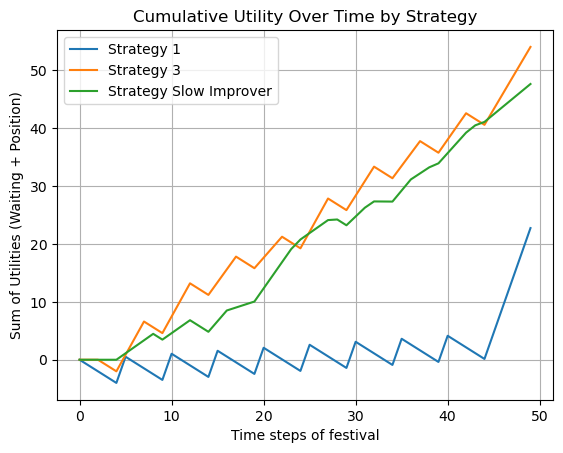

In [149]:
import matplotlib.pyplot as plt
import numpy as np

# Group agents by strategy
agents_by_strategy = {strategy: [agent for agent in agents if agent.strategy == strategy] for strategy in strategies}

# Initialize sum of utilities for each strategy
sum_utilities = {strategy: np.zeros(festival_duration) for strategy in strategies}

# Calculate cumulative utilities for each strategy
for strategy, agent_list in agents_by_strategy.items():
    for agent in agent_list:
        sum_utilities[strategy] += agent.waiting_utility_history + agent.position_utility_history
    if len(agent_list) > 0:  # Normalize only if there are agents with this strategy
        sum_utilities[strategy] /= len(agent_list)

# Plot the utilities
timesteps = np.arange(festival_duration)
for strategy, utility in sum_utilities.items():
    plt.plot(timesteps, utility, label=f"Strategy {strategy}")

print("Proportions of each class", probabilities)

# Configure the plot
plt.xlabel("Time steps of festival")
plt.ylabel("Sum of Utilities (Waiting + Position)")
plt.title("Cumulative Utility Over Time by Strategy")
plt.legend()
plt.grid(True)
plt.show()


How did the simulation go?

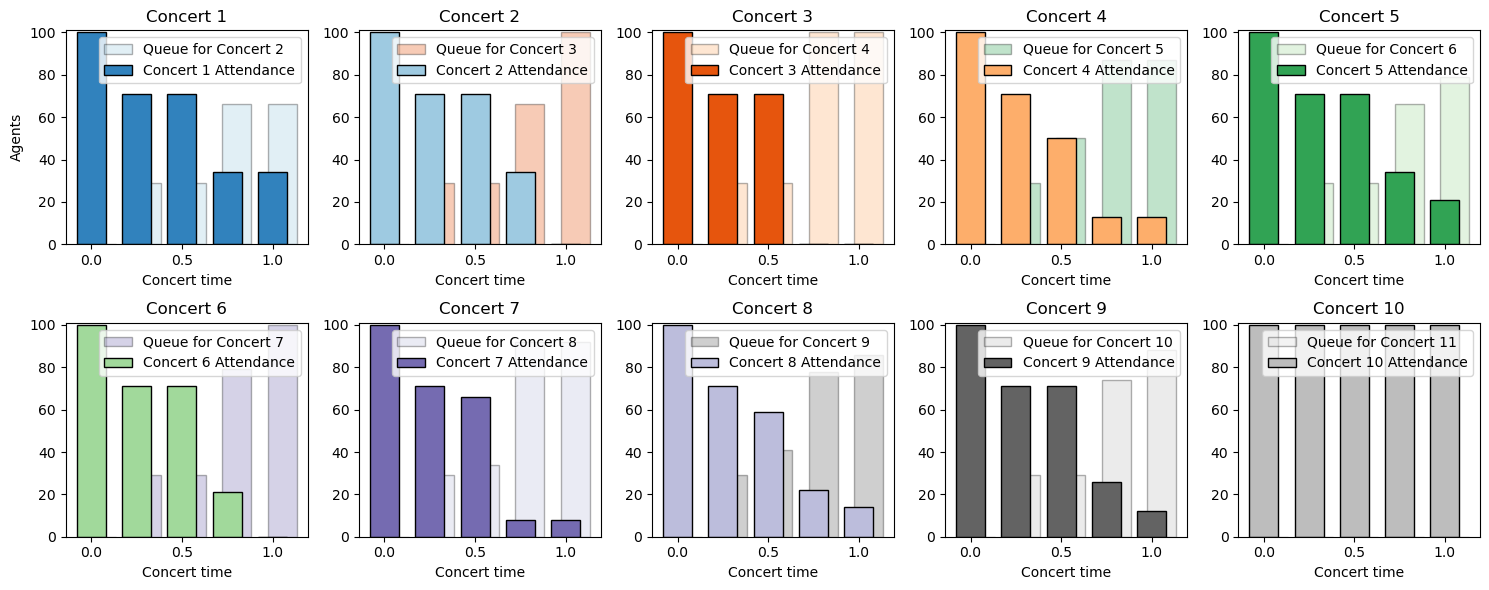

In [150]:
from graphs import BarGraph
A = np.zeros([nr_concerts, int(festival_duration)])

agent_concert = []

# Make dataset
for agent in agents:
    agent_concert.append(agent.concert_history)

for agent in agent_concert:
    t = 0
    for i in agent:
        A[i, t] += 1
        t += 1

graph = BarGraph(A)
graph.plot_data(5)

Some stuff that is sad to delete

In [151]:
# def get_action_2(agent, timestep, max_time):
#     # Stay at the consert
#     if (agent.strategy == 1):
#         if (timestep == max_time - 1):
#             action = 'leave'
#         else:
#             action = 'stay'
        
#     # Leave to the next concert as early as possible
#     if (agent.strategy == 2):
#         if (timestep == 0):
#             action = 'leave'
#         else:
#             print("Leaving agent stayed")

#     # Gows in the middle of the concert
#     if (agent.strategy == 3):
#         if (timestep == np.round(max_time/2)):
#             action = 'leave'
#         else:
#             action = 'stay'

#     return action

C:\Users\augus\AppData\Local\Temp\ipykernel_31548\1916505457.py:20: RuntimeWarning: invalid value encountered in true_divide
  sum_utility_leave = sum_utility_leave / len(agents_strategy_leave)


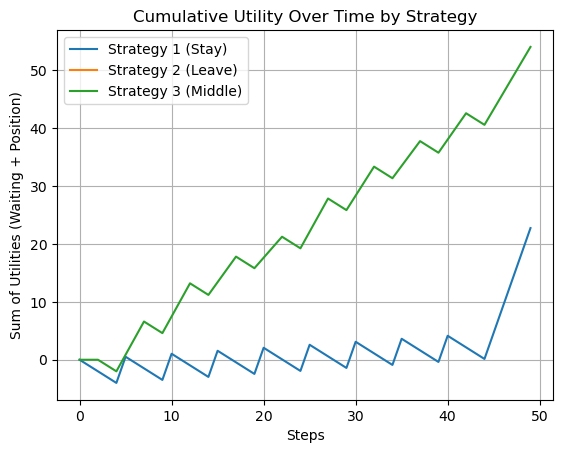

In [152]:
import matplotlib.pyplot as plt

agents_strategy_stay = [agent for agent in agents if agent.strategy == 1]
agents_strategy_leave = [agent for agent in agents if agent.strategy == 2]
agents_strategy_middle = [agent for agent in agents if agent.strategy == 3]

timesteps = np.arange(festival_duration)
sum_utility_stay = np.zeros(festival_duration)
sum_utility_leave = np.zeros(festival_duration)
sum_utility_middle = np.zeros(festival_duration)

# Sum utilities for strategy 1 (stay)
for agent in agents_strategy_stay:
    sum_utility_stay += agent.waiting_utility_history + agent.position_utility_history
sum_utility_stay = sum_utility_stay / len(agents_strategy_stay) #normalise

# Sum utilities for strategy 2 (leave)
for agent in agents_strategy_leave:
    sum_utility_leave += agent.waiting_utility_history + agent.position_utility_history
sum_utility_leave = sum_utility_leave / len(agents_strategy_leave)

# Sum startegy 3 (go in the middle)
for agent in agents_strategy_middle:
    sum_utility_middle += agent.waiting_utility_history + agent.position_utility_history
sum_utility_middle = sum_utility_middle / len(agents_strategy_middle)

plt.plot(timesteps, sum_utility_stay, label="Strategy 1 (Stay)")
plt.plot(timesteps, sum_utility_leave, label="Strategy 2 (Leave)")
plt.plot(timesteps, sum_utility_middle, label="Strategy 3 (Middle)")
plt.xlabel("Steps")
plt.ylabel("Sum of Utilities (Waiting + Position)")
plt.title("Cumulative Utility Over Time by Strategy")
plt.legend()
plt.grid(True)
plt.show()